# Zarr Database Summary & Validation

<br>

### Imports

In [1]:
import numpy as np
import pandas as pd

from satip import io

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import FEAutils as hlp
from warnings import warn
from ipypb import track

C:\Users\Ayrto\anaconda3\envs\satip_dev\lib\site-packages\google\auth\_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Downloading: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23rows/s]


<br>

### User Inputs

We have to specify the bucket where the data is located

In [2]:
zarr_bucket = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/zarr_full_extent_TM_int16'

<br>

### Loading Data

The `satip` wrapper for loading data will then generate an `xarray` `Dataset` when passed the path to the zarr bucket

In [3]:
ds = io.load_from_zarr_bucket(zarr_bucket)

ds['stacked_eumetsat_data']

<xarray.DataArray 'stacked_eumetsat_data' (time: 11652, x: 1870, y: 1831, variable: 12)>
dask.array<xarray-stacked_eumetsat_data, shape=(11652, 1870, 1831, 12), dtype=int16, chunksize=(36, 1870, 1831, 1), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2021-03-19T13:20:10 ... 2020-04-04T06:19:16
  * variable  (variable) object 'HRV' 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * x         (x) float64 -3.088e+06 -3.084e+06 ... 4.384e+06 4.388e+06
  * y         (y) float64 9.012e+06 9.008e+06 9.004e+06 ... 1.696e+06 1.692e+06
Attributes:
    meta:     {'orbital_parameters': {'projection_longitude': 9.5, 'projectio...

<br>

We'll quickly visualise the data coverage that's provided in the database.

N.b. Here we've made the assumption that an image is generated every 5 minutes.

The database coverage is currently at 5.0%


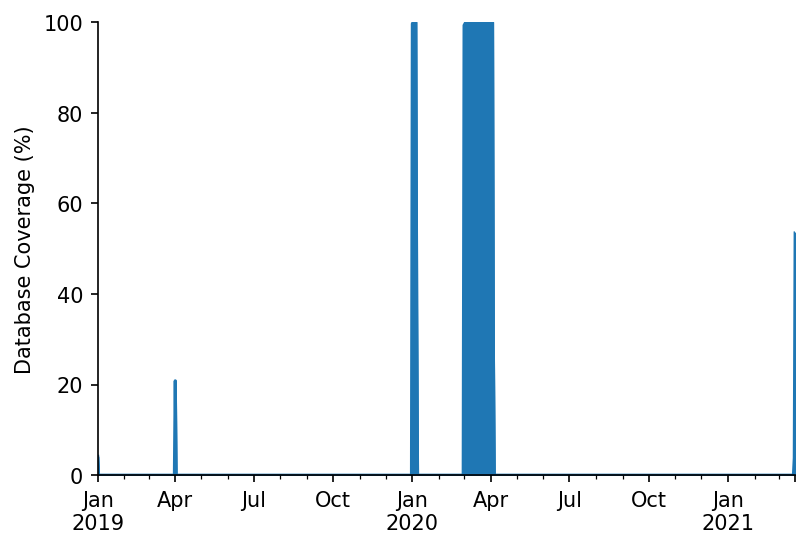

In [4]:
round_dt_idx = lambda dt_idx: pd.to_datetime(((dt_idx.astype(np.int64) // ns5min + 1 ) * ns5min))

ns5min = 5*60*1000000000

zarr_db_dts = pd.to_datetime(ds['stacked_eumetsat_data'].time.values)
dt_rng_5m = round_dt_idx(pd.date_range(zarr_db_dts.min(), zarr_db_dts.max(), freq='5T'))

s_db_coverage = pd.Series(round_dt_idx(zarr_db_dts)).value_counts().reindex(dt_rng_5m)
current_db_coverage = 1 - s_db_coverage.isnull().mean()

print(f'The database coverage is currently at {100*current_db_coverage:.1f}%')

# Plotting
fig, ax = plt.subplots(dpi=150)

s_db_coverage.resample('D').sum().pipe(lambda s: 100*s/s.max()).plot.area(ax=ax)

ax.set_ylim(0, 100)
ax.set_ylabel('Database Coverage (%)')
hlp.hide_spines(ax)

<br>

We'll create a slightly modified version of this that doesn't show percentage coverage for each day but instead considers each 5 minute period and groups batches of data that were retrieved sequentially 

In [5]:
#exports
def extract_dt_batch_sets(zarr_db_dts):
    dt_rng_split_idxs = (pd.Series(zarr_db_dts).diff(1).dt.total_seconds().abs() > (5 * 60 * 2)).replace(False, np.nan).dropna().index

    dt_batch_start_idxs = [0] + list(dt_rng_split_idxs)
    dt_batch_end_idxs = list(dt_rng_split_idxs-1) + [len(zarr_db_dts)-1]

    dt_batches = []

    for dt_batch_start_idx, dt_batch_end_idx in zip(dt_batch_start_idxs, dt_batch_end_idxs):
        dt_batches += [(zarr_db_dts[dt_batch_start_idx], zarr_db_dts[dt_batch_end_idx])]
        
    return dt_batches

 [████████████████████████████████████████████████████████████] 62/62 [06:28<00:10, 6.26s/it]

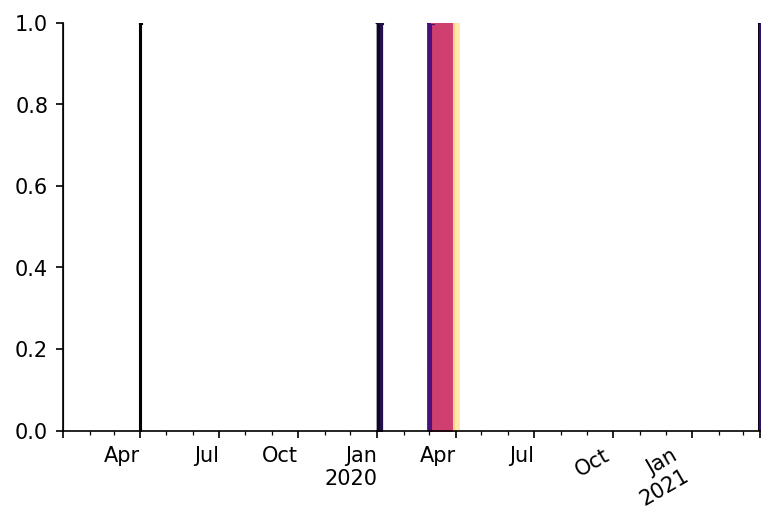

In [7]:
dt_batches = extract_dt_batch_sets(zarr_db_dts)

# Plotting
fig, ax = plt.subplots(dpi=150)

cmap = mpl.cm.get_cmap('magma')
total_dts_processed = 0

for batch_start_dt, batch_end_dt in track(dt_batches):
    if batch_start_dt == batch_end_dt:
        s_db_batch = pd.Series([1, 1], index=[batch_start_dt, batch_start_dt+pd.Timedelta(minutes=5)])
        total_dts_processed += 1
        batch_mid_pct_processed = total_dts_processed/zarr_db_dts.size
    else:
        s_db_batch = s_db_coverage[batch_start_dt:batch_end_dt]
        total_dts_processed += s_db_batch.size
        batch_mid_pct_processed = (total_dts_processed-(s_db_batch.size/2))/zarr_db_dts.size
        
    color = cmap(batch_mid_pct_processed)
    s_db_batch.plot.area(color=color, ax=ax)
    
ax.set_xlim(zarr_db_dts.min(), zarr_db_dts.max())
ax.set_ylim(0, 1)
hlp.hide_spines(ax)

<br>

### Offline Validation

In [126]:
num_dupes = zarr_db_dts.duplicated().sum()
assert num_dupes == 0, f'There are {num_dupes} duplicate indexes in the database'

In [ ]:
# heatmap with vertical strips for coverage
# colour of each strip will relate to position within the database

# also check for dupes
# add data validation checks

# Maybe have two layers of validation:
# 1) one runs in real-time when data is imported
# 2) more thorough 'offline' validation before releasing data to the public

# have a script in a static module which counts some stats.

<br>

We can then index this as we would any other `xarray` object

In [6]:
da_HRV_sample = ds['stacked_eumetsat_data'].isel(time=0).sel(variable='HRV')

da_HRV_sample

<xarray.DataArray 'stacked_eumetsat_data' (x: 1870, y: 1831)>
dask.array<getitem, shape=(1870, 1831), dtype=int16, chunksize=(1870, 1831), chunktype=numpy.ndarray>
Coordinates:
    time      datetime64[ns] 2021-03-19T13:20:10
    variable  <U3 'HRV'
  * x         (x) float64 -3.088e+06 -3.084e+06 ... 4.384e+06 4.388e+06
  * y         (y) float64 9.012e+06 9.008e+06 9.004e+06 ... 1.696e+06 1.692e+06
Attributes:
    meta:     {'orbital_parameters': {'projection_longitude': 9.5, 'projectio...

<br>

As well as visualise it, here we'll use `cartopy` to plot the data with a coastline overlay.

The darker area on the right hand side of the image are the areas where the sun has already set.

<ipython-input-7-5badebb6746d>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())


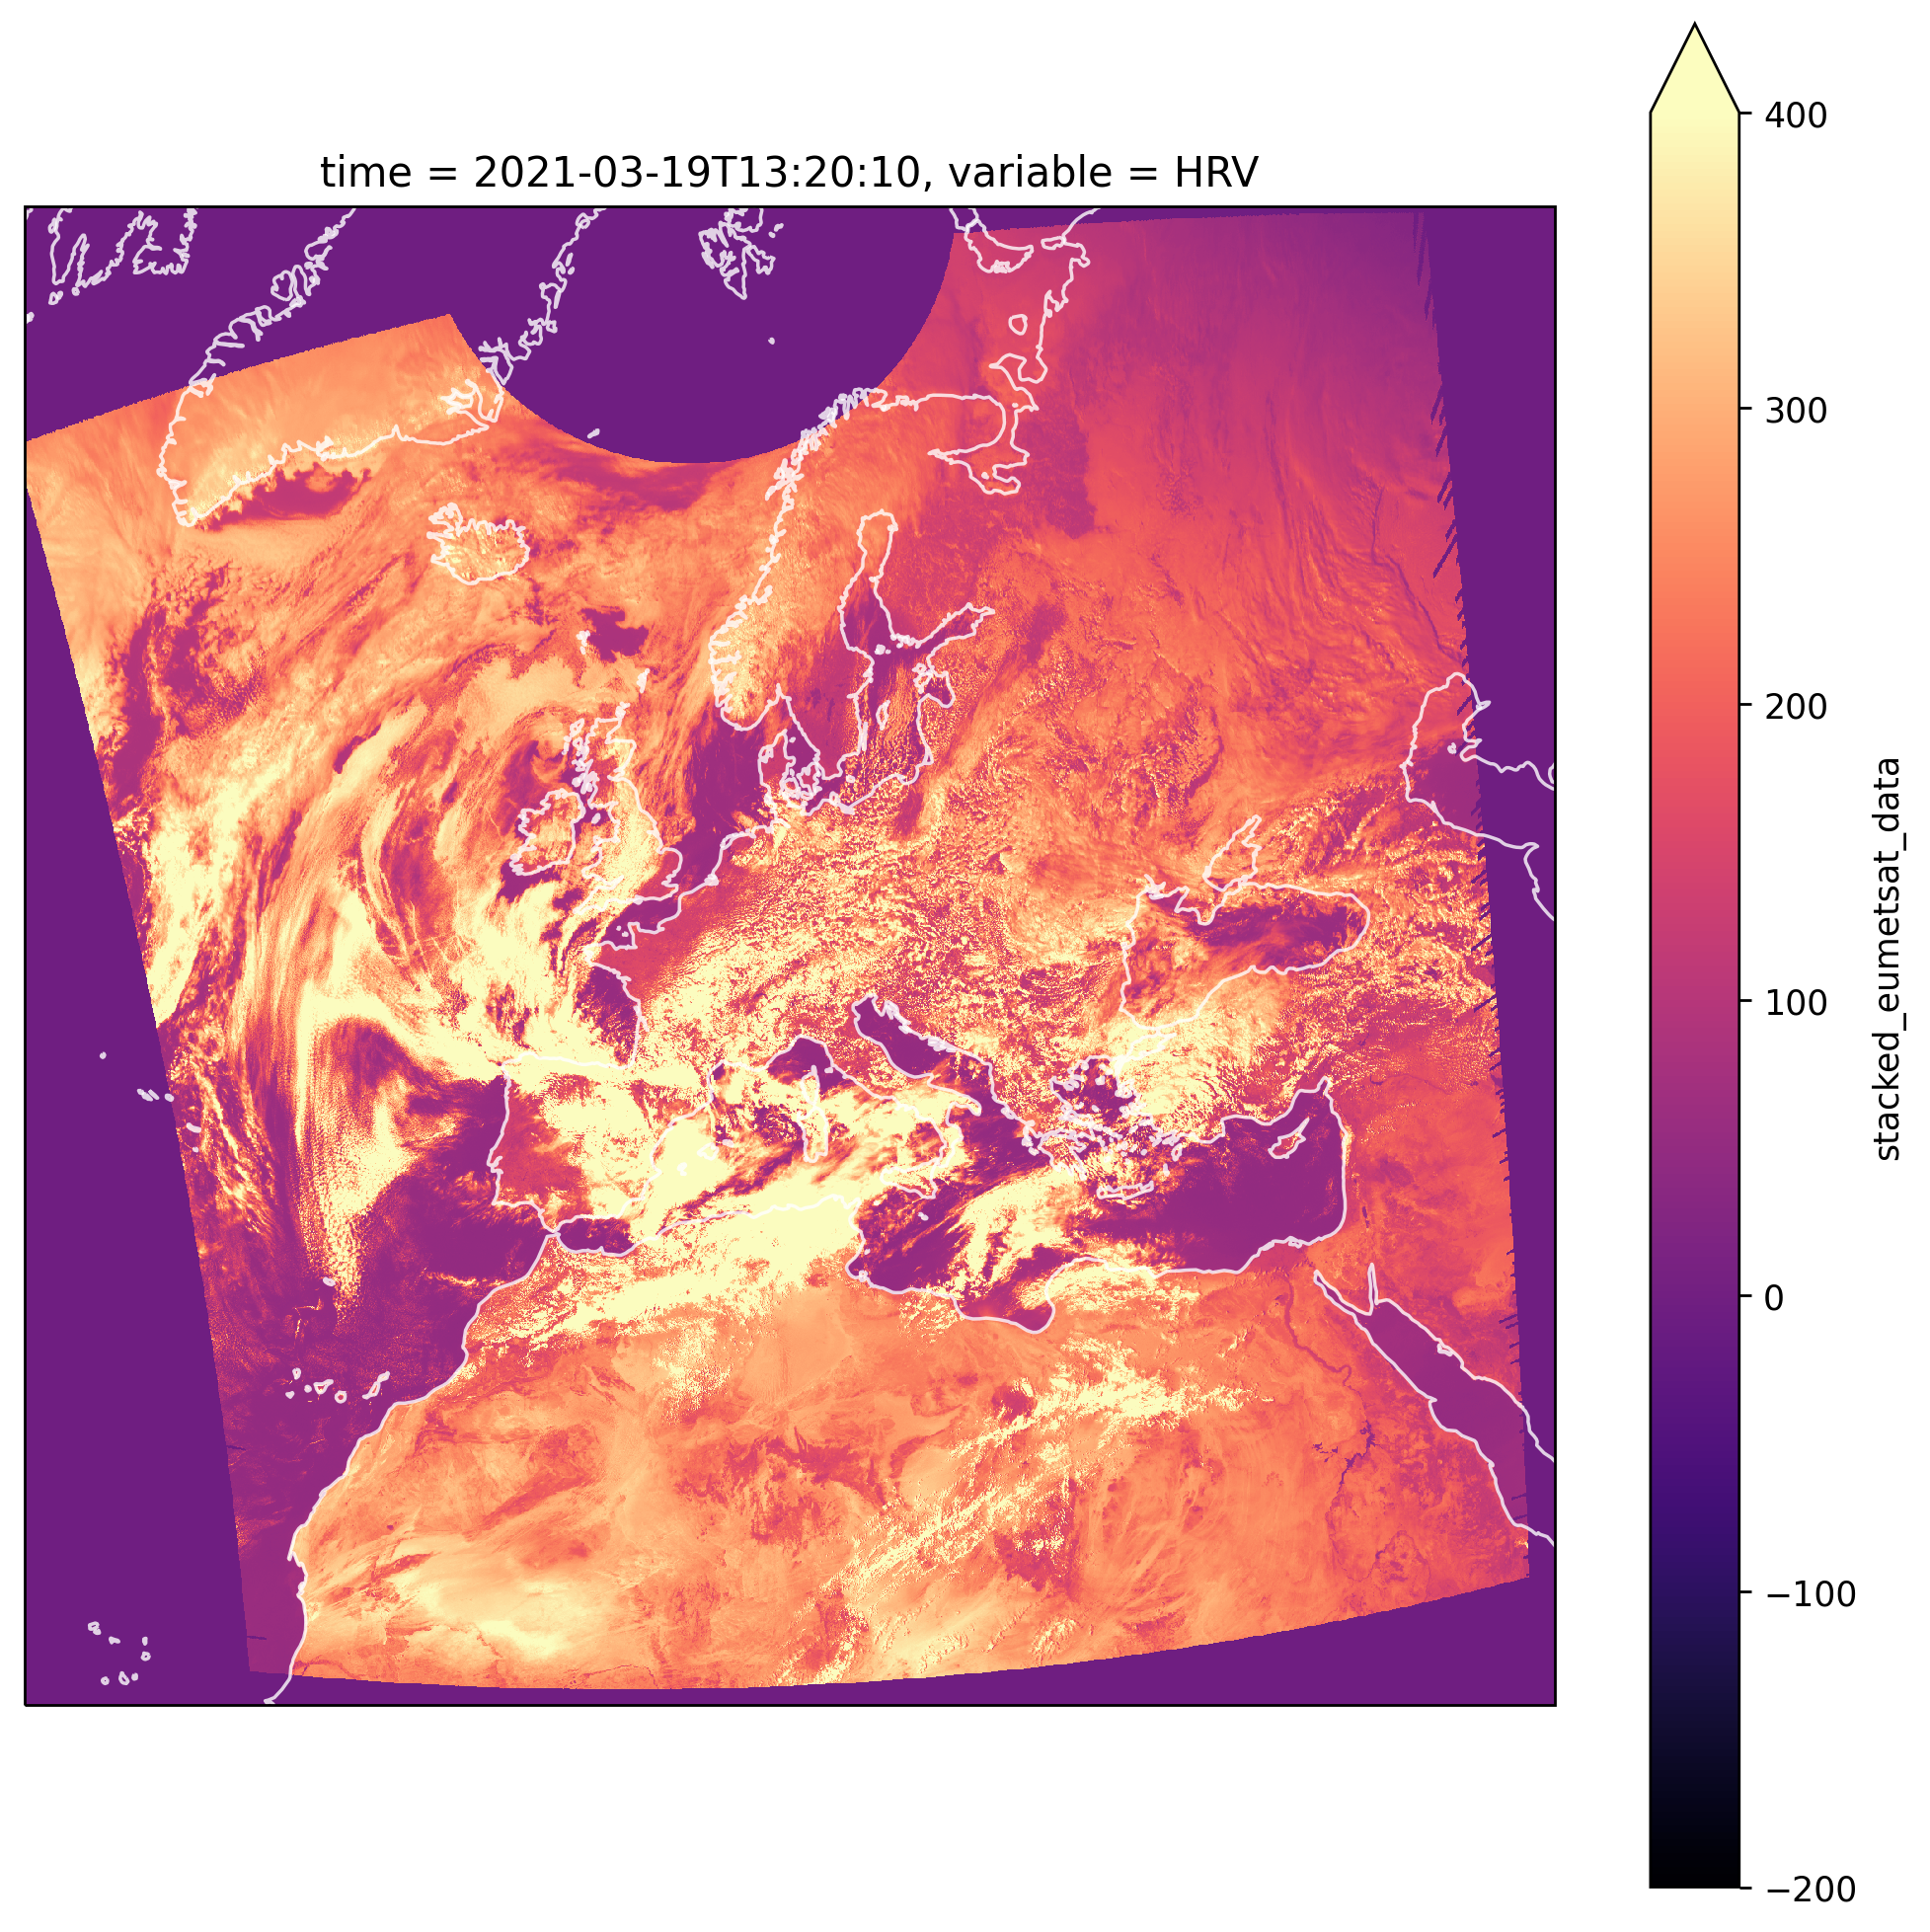

In [7]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

da_HRV_sample.T.plot.imshow(ax=ax, cmap='magma', vmin=-200, vmax=400)

ax.coastlines(resolution='50m', alpha=0.8, color='white')